In [750]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Cross validation
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.model_selection import KFold, ShuffleSplit

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# SQL access
import psycopg2

In [755]:
psql_info = {
    'database':'real_estate_data',
    'user':'MHollowed'
}

conn = psycopg2.connect(**psql_info)
cur = conn.cursor()

In [772]:
def execute_query(query):
    try:
        cur.execute(query)
        conn.commit()
        return cur.fetchall()
    except:
        conn.rollback()
        cur.execute(query)
        conn.commit()
        return cur.fetchall()

In [780]:
query = '''
    SELECT *
    FROM sales_info s
    LEFT JOIN property_info p
    ON s.major = p.major
    LIMIT 1
    ;
'''

In [781]:
execute_query(query)

ProgrammingError: operator does not exist: text = bigint
LINE 5:     ON s.major = p.major
                       ^
HINT:  No operator matches the given name and argument type(s). You might need to add explicit type casts.


In [783]:
# Let's start by reading in the first 1000 real estate sales in King County
file_path = '/Users/MHollowed/Desktop/final_project/HousingPricePredictor/data/csvs/EXTR_RPSale.csv'
df = pd.read_csv(file_path, nrows=100000)

In [624]:
df.iloc[0]

ExciseTaxNbr                                                    2671216
Major                                                             98400
Minor                                                               380
DocumentDate                                                 04/02/2014
SalePrice                                                             0
RecordingNbr                                             20140602000186
Volume                                                                 
Page                                                                   
PlatNbr                                                                
PlatType                                                               
PlatLot                                                                
PlatBlock                                                              
SellerName            DWORSHAK LYNDEE MARIE                         ...
BuyerName             DWORSHAK MICHAEL J                        

In [625]:
# Change 'DocumentDate' to DateTime
df['DocumentDate'] = pd.to_datetime(df['DocumentDate'])
# Get SaleYear and SaleMonth columns out of the DateTime object
df['SaleYear'] = pd.DatetimeIndex(df['DocumentDate']).year
df['SaleMonth'] = pd.DatetimeIndex(df['DocumentDate']).month

In [626]:
def filter_df(keep_values, col_name, df):
    mask = df[col_name].isin(keep_values)
    return df[mask]

In [627]:
'''
PrincipalUse value of 6 represents Residential buildings
Keep only sales with PrincipalUse value of 6
'''
principal_use_keep_values = [6]
df = filter_df(keep_values=principal_use_keep_values, col_name='PrincipalUse', df=df)

'''
PropertyType value of 1 represents Land Only
PropertyType value of 2 represents Land with New Building
PropertyType value of 3 represents Land with Previously Used Building
Keep only sales with PropertyType value in [1, 2, 3]
'''
property_type_keep_values = [1, 2, 3]
df = filter_df(property_type_keep_values, 'PropertyType', df)

'''
SaleInstrument value of 3 represents a Statutory Warranty Deed
By using this deed, the seller promises the buyer 
1. The seller is the owner of the property and has the right to sell it
2. No one else is possessing the property
3. There are no encumbrances against the property
4. No one with a better claim to the property will interfere with the transferee’s rights
5. The seller will defend certain claims regarding title to the property
'''
sale_instrument_keep_values = [3]
df = filter_df(sale_instrument_keep_values, 'SaleInstrument', df)

In [628]:
for column in df.columns:
    print(column, end=', ')

ExciseTaxNbr, Major, Minor, DocumentDate, SalePrice, RecordingNbr, Volume, Page, PlatNbr, PlatType, PlatLot, PlatBlock, SellerName, BuyerName, PropertyType, PrincipalUse, SaleInstrument, AFForestLand, AFCurrentUseLand, AFNonProfitUse, AFHistoricProperty, SaleReason, PropertyClass, SaleWarning, SaleYear, SaleMonth, 

In [629]:
# Shuffle dataframe
df = shuffle(df)

In [743]:
# Setting up first shitty model:

# Target value: SalePrice
y = df['SalePrice']

# Features:
#feature_ls = ['PropertyType', 'PrincipalUse', 'SaleInstrument', 'SaleReason', 'PropertyClass', 'SaleYear', 'SaleMonth']
feature_ls = ['PropertyType', 'SaleReason', 'PropertyClass', 'SaleYear', 'SaleMonth']


# Standardize the dataframe
#scalar = StandardScaler()
#X = scalar.fit_transform(df[feature_ls])

for feat in feature_ls:
    df[feat] = df[feat].astype('category')
    
X = df[feature_ls]

In [744]:
# Train Test Split Score
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Random Forest
model_RF = RandomForestRegressor()
model_RF.fit(X_train, y_train)
print("Random Forest Score: {}".format(model_RF.score(X_test, y_test)))

# Gradient Booster
model_GB = GradientBoostingRegressor()
model_GB.fit(X_train, y_train)
print("Gradient Booster Score: {}".format(model_GB.score(X_test, y_test)))

Random Forest Score: 0.8767186339084511
Gradient Booster Score: 0.8387911044725482


In [734]:
first_n_prediction_models = [model_RF, model_GB]

In [735]:
def print_first_n_predictions_vs_true_vals(model, X_test=X_test, y_test=y_test, n=10):
    print("\nFirst {} {} predictions vs true values".format(n, model.__class__.__name__))
    for y_hat, y_true in zip(model.predict(X_test[:n]), y_test[:n]):
        print("y_hat: {:7.0f} - y: {:5}".format(y_hat, y_true))
        
def print_feature_importances(model, feature_ls=feature_ls):
    print("\nFeature importances for {}".format(model.__class__.__name__))
    for feature_name, importance_level in zip(feature_ls, model.feature_importances_):
        print("{:14}: {:.3}%".format(feature_name, importance_level*100))

In [736]:
for model in first_n_prediction_models:
    print_first_n_predictions_vs_true_vals(model)


First 10 RandomForestRegressor predictions vs true values
y_hat:  342708 - y: 459950
y_hat:  683372 - y: 645000
y_hat:   39000 - y:     0
y_hat:  596261 - y: 545000
y_hat:  350067 - y: 310000
y_hat:  309119 - y: 450000
y_hat:  654656 - y: 560000
y_hat:  293199 - y: 310000
y_hat:  537508 - y: 350000
y_hat:       0 - y:     0

First 10 GradientBoostingRegressor predictions vs true values
y_hat:  418425 - y: 459950
y_hat:  511862 - y: 645000
y_hat:  454150 - y:     0
y_hat:  571300 - y: 545000
y_hat:  396273 - y: 310000
y_hat:  300755 - y: 450000
y_hat:  591457 - y: 560000
y_hat:  304444 - y: 310000
y_hat:  489444 - y: 350000
y_hat:  188485 - y:     0


In [747]:
# Pre-knockout
for model in first_n_prediction_models:
    print_feature_importances(model)


Feature importances for RandomForestRegressor
PropertyType  : 23.3%
SaleReason    : 0.591%
PropertyClass : 16.2%
SaleYear      : 3.98%
SaleMonth     : 56.0%

Feature importances for GradientBoostingRegressor
PropertyType  : 32.8%
SaleReason    : 5.17%
PropertyClass : 18.7%
SaleYear      : 14.1%
SaleMonth     : 29.1%


In [738]:
# Post-knockout
for model in first_n_prediction_models:
    print_feature_importances(model)


Feature importances for RandomForestRegressor
PropertyType  : 23.3%
SaleReason    : 0.591%
PropertyClass : 16.2%
SaleYear      : 3.98%
SaleMonth     : 56.0%

Feature importances for GradientBoostingRegressor
PropertyType  : 32.8%
SaleReason    : 5.17%
PropertyClass : 18.7%
SaleYear      : 14.1%
SaleMonth     : 29.1%


In [739]:
# Pre-knockout
# Cross Val Score
model_cv_RF = RandomForestRegressor()
model_cv_GB = GradientBoostingRegressor()
print(cross_val_score(model_cv_RF, X, y, cv=10).mean())
print(cross_val_score(model_cv_GB, X, y, cv=10).mean())

0.897191905974
0.840077049179


In [745]:
# Post-knockout
# Cross Val Score
model_cv_RF = RandomForestRegressor()
model_cv_GB = GradientBoostingRegressor()
print(cross_val_score(model_cv_RF, X, y, cv=10).mean())
print(cross_val_score(model_cv_GB, X, y, cv=10).mean())

0.901545411848
0.840077302852


In [741]:
# Fit on full dataset
model_full_fit_RF = RandomForestRegressor()
model_full_fit_GB = GradientBoostingRegressor()
model_full_fit_RF.fit(X, y)
model_full_fit_GB.fit(X, y);

In [647]:
print_first_n_predictions_vs_true_vals(model_RF)

First 10 RandomForestRegressor predictions vs true values
y_hat:  300405 - y: 240000
y_hat:  681960 - y: 366000
y_hat:  446020 - y: 442000
y_hat:  298539 - y: 212000
y_hat:  202129 - y: 299950
y_hat:  245500 - y: 215000
y_hat:  198833 - y:     0
y_hat:  526413 - y: 404540
y_hat:  166820 - y: 295000
y_hat:  248048 - y: 220000


In [682]:
X.shape

(34208, 5)

In [696]:
feature_ls

['PropertyType', 'SaleReason', 'PropertyClass', 'SaleYear', 'SaleMonth']

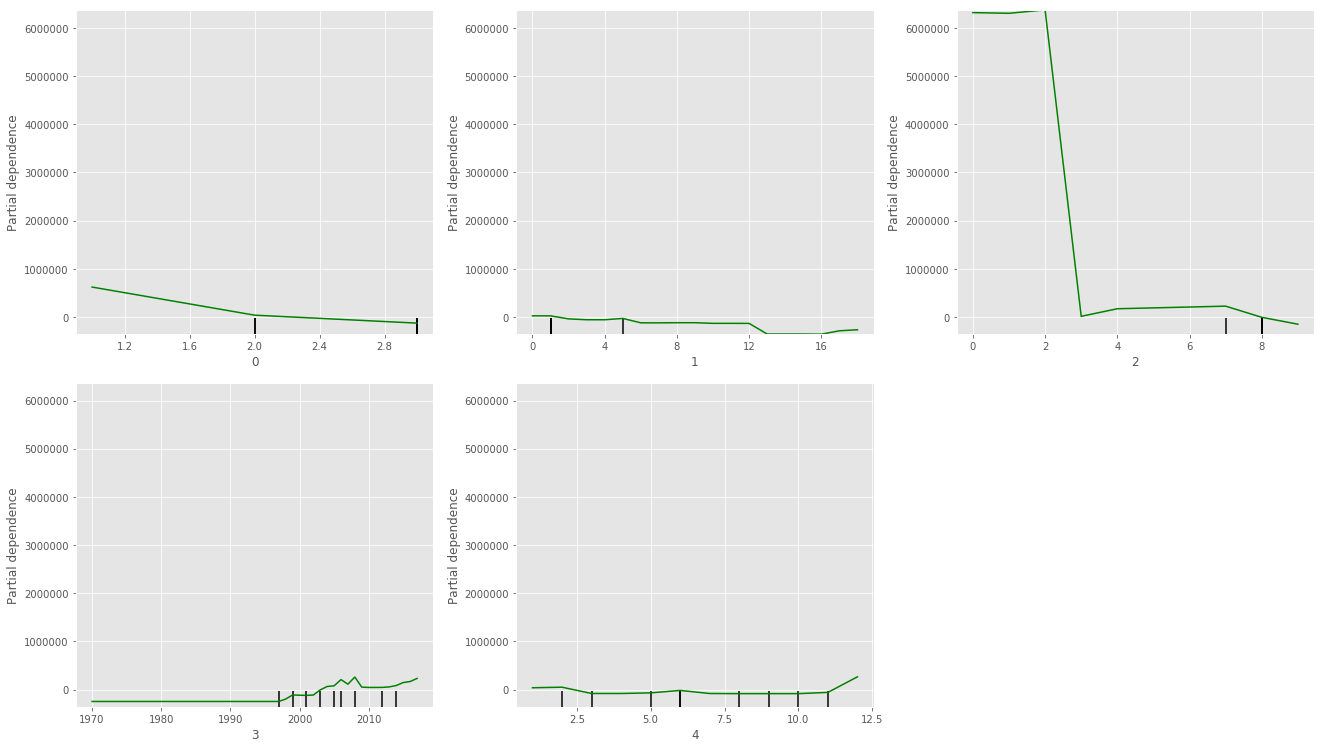

In [746]:
plot_partial_dependence(model_GB, X, range(5))    

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.tight_layout()

In [706]:
feature_ls

['PropertyType', 'SaleReason', 'PropertyClass', 'SaleYear', 'SaleMonth']

In [714]:
dummy_df = pd.get_dummies(df['PropertyType']) + \
            pd.get_dummies(df['SaleReason']) + \
            pd.get_dummies(df['PropertyClass']) + \
            pd.get_dummies(df['SaleYear']) + \
            pd.get_dummies(df['SaleMonth'])


In [718]:
dummy_df = dummy_df.fillna(0)

In [ ]:
df['PropertyClass'].value_counts()

In [303]:
df['SaleReason'].value_counts()

1     18366
18     3039
5      1748
10     1596
13     1358
8      1226
14     1015
4       878
11      844
16      434
9       244
12      177
0       109
6        70
19       38
2        20
17       19
7        17
3         2
15        2
Name: SaleReason, dtype: int64

In [304]:
df['PropertyType'].value_counts()

3     24759
1      2787
2      2468
11      665
0       241
4       192
10       32
91       19
6        14
5         7
99        4
14        4
18        2
12        2
83        1
9         1
49        1
96        1
48        1
95        1
Name: PropertyType, dtype: int64

In [305]:
for i,j in sorted(zip(df['PrincipalUse'].value_counts().index, df['PrincipalUse'].value_counts()), key=lambda x:x[0]):
    print(i,j)

6 31202


# Creating dummy cols for the following features:
1. PropertyType - The type of property as reported on the Excise Tax affidavit.
2. PrincipalUse - The primary use of the property as reported on the Excise Tax affidavit.
3. SaleInstrument - The type of document as reported on the Excise Tax affidavit.
4. AFForestLand - Indicates whether or not the property was reported on the Excise Tax affidavit as classified or designated forest land.
5. AFCurrentUseLand - Indicates whether or not the property was reported on the Excise Tax affidavit as classified current use land.
6. AFNonProfitUse - Indicates whether or not the property was reported on the Excise Tax affidavit as exempt from property tax as a nonprofit organization.
7. AFHistoricProperty - Indicates whether or not the property was reported on the Excise Tax affidavit as receiving special valuation as historic property.
8. SaleReason - 
9. PropertyClass - 
10. SaleWarning - 

In [779]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34208 entries, 69000 to 22388
Data columns (total 26 columns):
ExciseTaxNbr          34208 non-null int64
Major                 34208 non-null int64
Minor                 34208 non-null int64
DocumentDate          34208 non-null datetime64[ns]
SalePrice             34208 non-null int64
RecordingNbr          34208 non-null object
Volume                34208 non-null object
Page                  34208 non-null object
PlatNbr               34208 non-null object
PlatType              34208 non-null object
PlatLot               34208 non-null object
PlatBlock             34208 non-null object
SellerName            34208 non-null object
BuyerName             34208 non-null object
PropertyType          34208 non-null category
PrincipalUse          34208 non-null int64
SaleInstrument        34208 non-null int64
AFForestLand          34208 non-null object
AFCurrentUseLand      34208 non-null object
AFNonProfitUse        34208 non-null object
AFH

In [ ]:
# Grabbing target column
y = df['SalePrice']
# Grabbing columns with possible predictive value
feature_cols = ['']

In [3]:
df.describe()

,ExciseTaxNbr,Major,Minor,SalePrice,PropertyType,PrincipalUse,SaleInstrument,SaleReason,PropertyClass
count,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,1.917884e+06,389507.526000,1670.511000,1.491961e+06,2.534000,4.662000,7.124000,4.97900,6.172000
std,5.006907e+05,304066.620523,3050.380162,2.463704e+06,2.111232,2.739573,6.818293,6.30907,2.487691
min,6.668730e+05,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000
25%,1.504229e+06,132812.500000,110.000000,0.000000e+00,1.000000,2.000000,3.000000,1.00000,3.000000
50%,1.933697e+06,297432.500000,298.000000,2.287250e+05,3.000000,6.000000,3.000000,1.00000,8.000000
75%,2.341504e+06,701260.500000,920.000000,2.025000e+06,3.000000,6.000000,15.000000,9.00000,8.000000
max,2.864540e+06,982920.000000,9571.000000,1.340000e+07,59.000000,11.000000,27.000000,19.00000,9.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
ExciseTaxNbr          1000 non-null int64
Major                 1000 non-null int64
Minor                 1000 non-null int64
DocumentDate          1000 non-null object
SalePrice             1000 non-null int64
RecordingNbr          1000 non-null object
Volume                1000 non-null object
Page                  1000 non-null object
PlatNbr               1000 non-null object
PlatType              1000 non-null object
PlatLot               1000 non-null object
PlatBlock             1000 non-null object
SellerName            1000 non-null object
BuyerName             1000 non-null object
PropertyType          1000 non-null int64
PrincipalUse          1000 non-null int64
SaleInstrument        1000 non-null int64
AFForestLand          1000 non-null object
AFCurrentUseLand      1000 non-null object
AFNonProfitUse        1000 non-null object
AFHistoricProperty    1000 non-null objec

In [10]:
df.iloc[0:1].T

,0
ExciseTaxNbr,2671216
Major,98400
Minor,380
DocumentDate,04/02/2014
SalePrice,0
RecordingNbr,20140602000186
Volume,
Page,
PlatNbr,
PlatType,


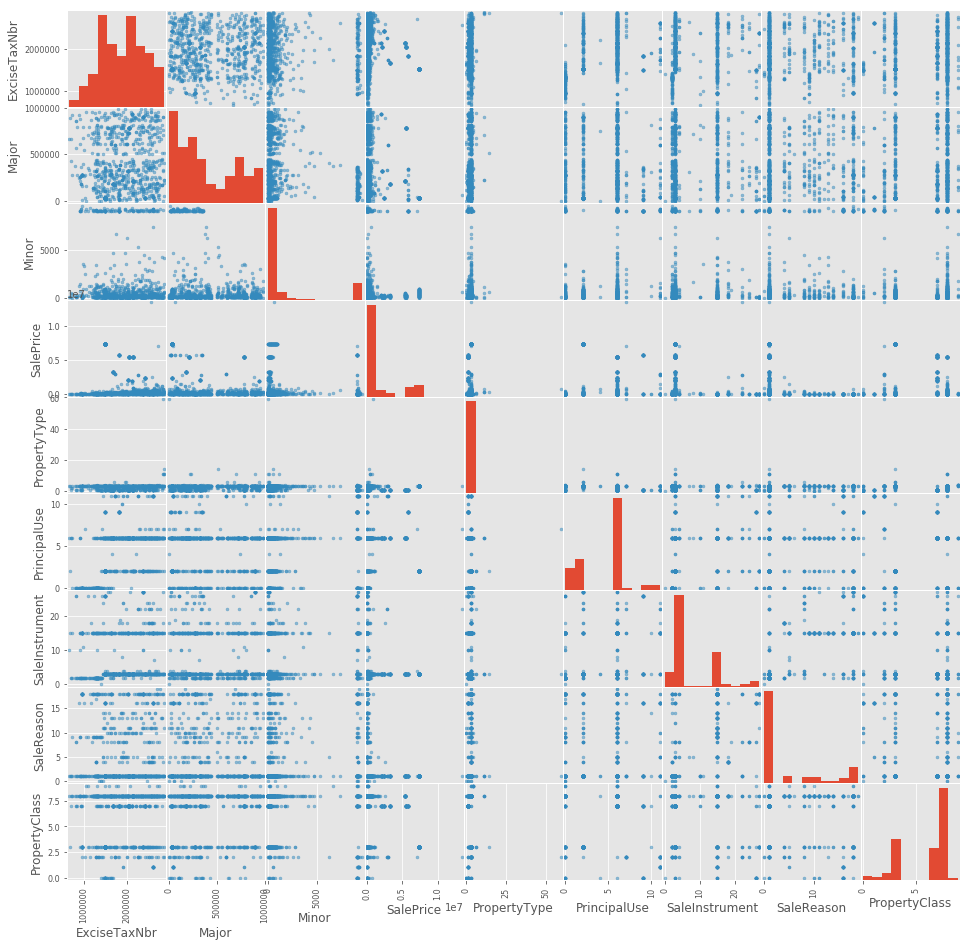

In [18]:
pd.tools.plotting.scatter_matrix(df, figsize=(16,16));

In [19]:
['DWORSHAK' == df_['SellerName'][:2].str.lower()]

[0    False
 1    False
 Name: SellerName, dtype: bool]

In [14]:
mask = df_['DWORSHAK' in df['SellerName']]
#df_[mask].head().T

KeyError: False